In [1]:
import pandas as pd
import numpy as np
import requests
from PIL import Image, ImageEnhance
from io import BytesIO
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string


In [4]:
df = pd.read_csv("A2_Data.csv")
df = df.dropna()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nalishjain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nalishjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nalishjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df.head()

,Id,Image,Review Text
0,3452,['https://images-na.ssl-images-amazon.com/imag...,Loving these vintage springs on my vintage str...
1,1205,['https://images-na.ssl-images-amazon.com/imag...,Works great as a guitar bench mat. Not rugged ...
2,1708,['https://images-na.ssl-images-amazon.com/imag...,We use these for everything from our acoustic ...
3,2078,['https://images-na.ssl-images-amazon.com/imag...,Great price and good quality. It didn't quite...
4,801,['https://images-na.ssl-images-amazon.com/imag...,I bought this bass to split time as my primary...


In [48]:
image_text_dict = {}
count = 0
for index, row in df.iterrows():
    urls = row['Image']
    url_list = json.loads(urls.replace("'", "\""))
    text = row['Review Text']
    for url in url_list:
        image_text_dict[count] = (url,text)
        count += 1


In [49]:
def cosine_similarity(vector1, vector2):
    dot_prod = np.dot(vector1, vector2)
    mag_vector1 = np.linalg.norm(vector1)
    mag_vector2 = np.linalg.norm(vector2)

    if mag_vector1 == 0 or mag_vector2 == 0:
        return 0  
    return dot_prod / (mag_vector1 * mag_vector2)

def find_top_similar_keys(query_vector, vectors_dict, top_n=3):
    similarities = {}

    for key, vector in vectors_dict.items():
        similarities[key] = cosine_similarity(query_vector, vector)

    sorted_keys = sorted(similarities, key=similarities.get, reverse=True)
    top_keys = sorted_keys[:top_n]
    top_scores = [similarities[key] for key in top_keys]

    return top_keys, top_scores

In [50]:

def preprocess_image(img_url, factor = 0.5):
    # Make an HTTP request to the specified image URL and get the response
    response = requests.get(img_url)
    
    # Open the image using the PIL (Python Imaging Library) from the response content

    img = Image.open(BytesIO(response.content))

    img = img.resize((224, 224)) #Resizing
    
    enhancer = ImageEnhance.Brightness(img) #increasing brightness
    img = enhancer.enhance(factor)

    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True) #random flips


    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array =  datagen.flow(img_array).next()
    img_array = preprocess_input(img_array)
    
    return img_array

def extract_image_features(model, img_array):
    features = model.predict(img_array)
    features = features.flatten()
    return features

def preprocess_text(text):
    text = text.lower()

    tokens = word_tokenize(text)

    # Removing punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # Stop word removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Rejoin the tokens to form the preprocessed text
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [51]:

invalid_url_ids = []
for i in range(len(image_text_dict)):
    try:
        Image.open(BytesIO(requests.get(image_text_dict[i][0]).content))
    except:
        invalid_url_ids.append(i)
image_text_dict = {key: value for key, value in image_text_dict.items() if key not in invalid_url_ids}
print(len(image_text_dict))

1639


In [52]:
base_model = VGG16(weights='imagenet')
image_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
print(image_model.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [53]:
# Apply image feature extraction to each image in the dataset
url_ids = list(image_text_dict.keys())
img_features = []
for url_id in url_ids:
    img_array = preprocess_image(image_text_dict[url_id][0])
    img_feature = extract_image_features(image_model, img_array)
    img_features.append(img_feature.reshape(4096))

img_features = normalize(np.array(img_features), norm='l2', axis=1)

img_features_dict = {}

count = 0
for url_id in url_ids:
    img_features_dict[url_id] = img_features[count]
    count +=1

with open('img_features_dict.pkl', 'wb') as f:
    pickle.dump(img_features_dict, f)

1/1 [==============================] - 0s 111ms/step


In [54]:
img_features_dict[0].shape

(4096,)

In [55]:
url_ids = list(image_text_dict.keys())
text_reviews = {}
for url_id in url_ids:
    pp_text = preprocess_text(image_text_dict[url_id][1])
    text_reviews[url_id] = pp_text
# print(text_reviews)

tf = {}
idf = {}
tf_idf = {}
word_id = {}
word_id_iter = 0
for url_id in text_reviews.keys():
    # calculating idf
    word_list = text_reviews[url_id].split()

    tf[url_id] = {}
    for word in set(word_list):
        if word not in idf:
            idf[word] = 1
            word_id[word] = word_id_iter
            word_id_iter += 1
        else:
            idf[word] += 1
    # calculating tf
    for word in word_list:
        if word not in tf[url_id]:
            tf[url_id][word] = 1 
        else:
            tf[url_id][word] += 1             

for url_id in text_reviews.keys():
    word_list = text_reviews[url_id].split()
    tf_idf[url_id] = np.zeros(shape = (len(idf)))

    for word in set(word_list): 
        # tf_idf[url_id][word_id[word]] = np.log(len(image_text_dict)/idf[word])*tf[url_id][word]/len(word_list)       
        tf_idf[url_id][word_id[word]] = np.log(len(image_text_dict)/idf[word])*tf[url_id][word] 
  

# print(tf_idf[0])
# print(word_id)
# print(tf_idf[0].shape)
with open('tf_idf.pkl', 'wb') as f:
    pickle.dump(tf_idf, f)


In [56]:
print(len(idf))

6046


In [57]:
def user_input(img_url, text):
    img_array = preprocess_image(img_url)
    img_vector = extract_image_features(image_model, img_array).reshape(4096)
    print(img_vector.shape)
    top_url_ids_img, cosine_scores = find_top_similar_keys(img_vector, img_features_dict)
    print(top_url_ids_img, cosine_scores)

    pp_text =  preprocess_text(text)
    words = pp_text.split(" ")
    text_vector = np.zeros(shape = (len(idf)))

    freq_words = {}
    for word in words: 
        if word not in freq_words:
            freq_words[word] = 1
        else:
            freq_words[word] += 1
    
    for word in set(words):
        # text_vector[word_id[word]] = freq_words[word]*np.log(len(image_text_dict)/idf[word])/len(words)     
        text_vector[word_id[word]] = freq_words[word]*np.log(len(image_text_dict)/idf[word])    
    
    top_url_ids_img, cosine_scores = find_top_similar_keys(text_vector, tf_idf)
    print(top_url_ids_img, cosine_scores)


               
    
    


In [64]:
test_url = 'https://images-na.ssl-images-amazon.com/images/I/71bztfqdg+L._SY88.jpg'
test_text = 'I have been using Fender locking tuners for about five years on various strats and teles. Definitely helps with tuning stability and way faster to restring if there is a break.'
user_input(image_text_dict[56][0], image_text_dict[56][1])

1/1 [==============================] - 0s 113ms/step
(4096,)
[56, 1240, 1337] [0.7689313, 0.585966, 0.585966]
[56, 1458, 1049] [0.9999999999999998, 0.22819124395021, 0.14885918029236567]


In [59]:
image_text_dict[1244]

('https://images-na.ssl-images-amazon.com/images/I/71bztfqdg+L._SY88.jpg',
 'I have been using Fender locking tuners for about five years on various strats and teles. Definitely helps with tuning stability and way faster to restring if there is a break.')

(1, 224, 224, 3)


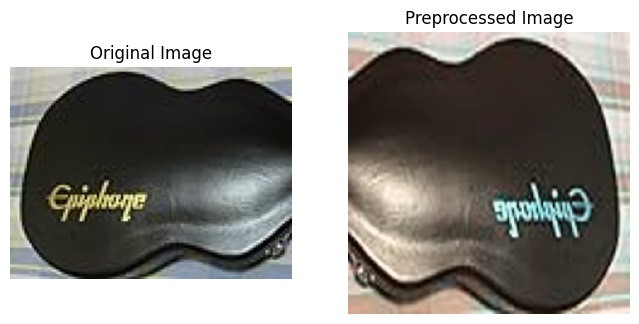

In [60]:
example_img_url = image_text_dict[70][0]
preprocessed_img_array = preprocess_image(example_img_url, factor = 1.2)
print(preprocessed_img_array.shape)
# Convert the preprocessed image array back to a PIL Image for visualization
preprocessed_img = image.array_to_img(preprocessed_img_array[0])

# Display the original and preprocessed images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Image.open(BytesIO(requests.get(example_img_url).content)))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Preprocessed Image")
plt.imshow(preprocessed_img)
plt.axis("off")
plt.show()